# Taichung DE Forecast  with Xgboost

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Visualizing Data

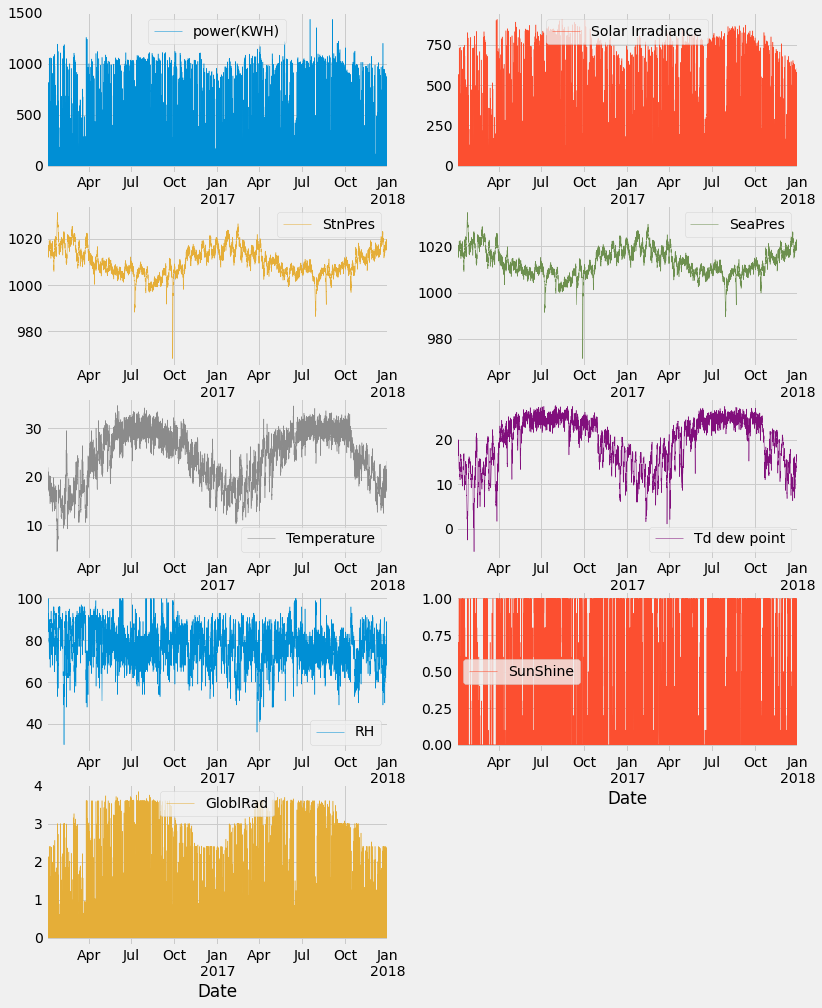

In [2]:
# quick look data
data = pd.read_csv('data\\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(5, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

# Generating Features

Generating time lag.

According to SARIMA analysis result: choose time lag 1, 24.

In [3]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i)] = df[col].shift(i)
    return df

for col in data.columns:
    data_lag=create_lags(data, col,[1,24])

data_lag.dropna(inplace=True)

Choose day time.

Generating time feature.

In [4]:
# choose day time
daytime_idx = (6<= data_lag.index.hour) & (data_lag.index.hour<= 18)
data_daytime = data_lag[daytime_idx]

In [5]:
# generate time feature
data_daytime.loc[:,'Hour'] = data_daytime.index.hour
data_daytime.loc[:,'day_of_year'] = data_daytime.index.dayofyear

generate morning and afternoon.

In [6]:
# One of N encoding.
def morning_afternoon(hour):
    if 6<= hour <=12:
        return 'morning'
    else:
        return 'afternoon'

data_daytime['period'] = data_daytime['Hour'].apply(morning_afternoon)
data_daytime = data_daytime.join(pd.get_dummies(data_daytime['period']))
data_daytime.drop(columns=['period'], inplace=True)
print(data_daytime.head(1))

                     power(KWH)  Solar Irradiance  StnPres  SeaPres  \
Date                                                                  
2016-01-02 06:00:00         0.0          3.023185   1019.4   1022.6   

                     Temperature  Td dew point    RH  SunShine  GloblRad  \
Date                                                                       
2016-01-02 06:00:00         17.8          15.4  86.0       0.0       0.0   

                     power(KWH)_Lag_1  ...  RH_Lag_1  RH_Lag_24  \
Date                                   ...                        
2016-01-02 06:00:00               0.0  ...      85.0       80.0   

                     SunShine_Lag_1  SunShine_Lag_24  GloblRad_Lag_1  \
Date                                                                   
2016-01-02 06:00:00             0.0              0.0             0.0   

                     GloblRad_Lag_24  Hour  day_of_year  afternoon  morning  
Date                                                        

Choosing features and targets.

In [7]:
Feature = data_daytime.loc[:, 'power(KWH)_Lag_1':]
Target = data_daytime.loc[:, 'power(KWH)']

# Split train and test data.

choose last 4 month to validation model.

In [8]:
# Split train and test data
X_train, X_test, y_train, y_test = Feature[:'2017-08-31'], Feature['2017-09-01':], Target[:'2017-08-31'], Target['2017-09-01':]

# Tune Parameters
Time series can't use cross validtion.

You can't use future data to predict past.

In [9]:
gbm = xgb.XGBRegressor()
gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                  'n_estimators': [200],
                  'subsample': np.arange(0.05,1.05,.05)}
randomized_neg_mse = RandomizedSearchCV(
                     estimator=gbm, param_distributions=gbm_param_grid,
                     n_iter=10, scoring='neg_mean_squared_error', 
                     cv=TimeSeriesSplit(n_splits=5), verbose=1)
randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   54.7s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          validate_parameters=None,
                                          verbosity=None),
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 

In [10]:
print("Best mse: ", np.abs(randomized_neg_mse.best_score_))
print("Best model: ", randomized_neg_mse.best_estimator_)

Best mse:  6165.702741843859
Best model:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [11]:
preds=randomized_neg_mse.predict(X_test)

# Visualizing result

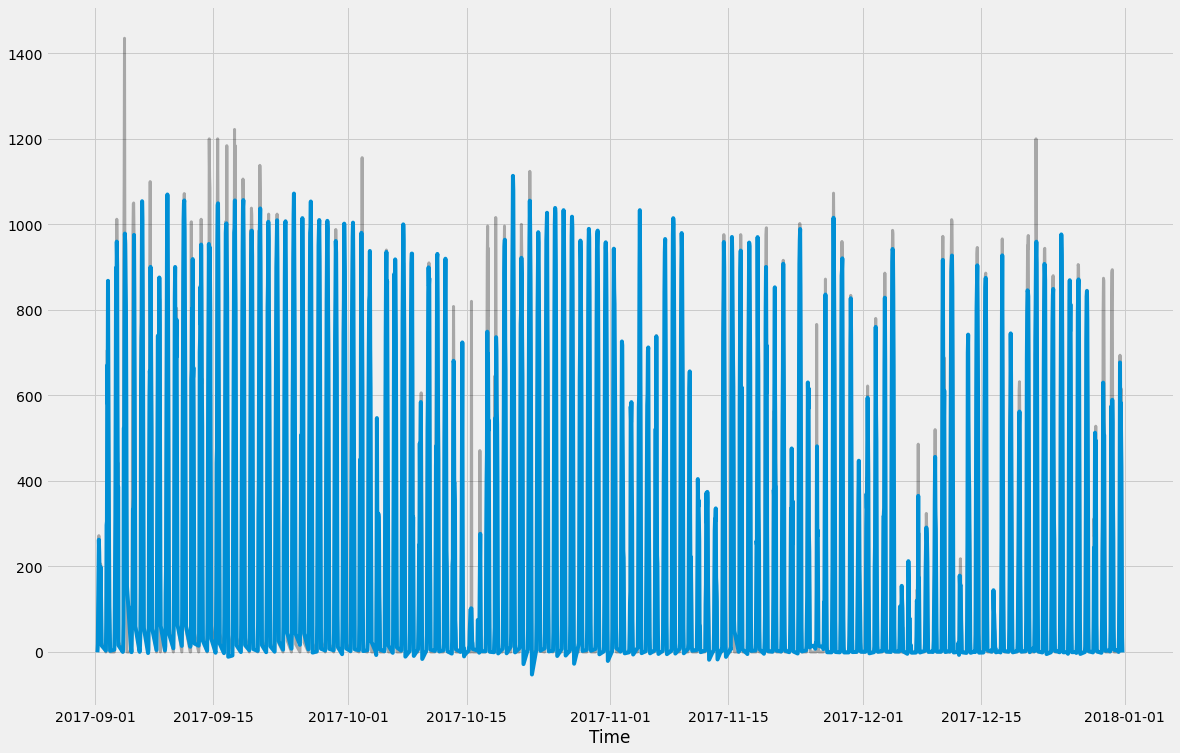

In [12]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, preds)
ax.set(xlabel="Time")
plt.show()

# Model Score 

In [13]:
# Compute and print the reslut
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

def print_results(y_test, y_predict):
    print('Root mean squared error:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict))))
    print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
    print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
    print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))

print_results(y_test, preds)

Root mean squared error:98.5680
Mean absolute error:46.5779
Mean relative error:3.25%
Coefficient of determination:0.9215


# Look at Worst and Best Predicted Days

In [14]:
test_days = pd.DataFrame(y_test)
test_days['Predicted'] = preds 
test_days['error'] = test_days['power(KWH)'] - test_days['Predicted']
test_days['abs_error'] = test_days['error'].apply(np.abs)
test_days['year']=test_days.index.year
test_days['month']=test_days.index.month
test_days['day']=test_days.index.day

error_by_day = test_days.groupby(['year','month','day']).mean()[['power(KWH)','Predicted','error','abs_error']]

Looking worst predicted ten days.

In [15]:
def look_ten(data, Best=True):
    top_ten=data.sort_values('abs_error', ascending=Best).head(10)
    top_date = top_ten.index[0]
    top_date = str(top_date[0])+'-'+str(top_date[1])+'-'+str(top_date[2])
    print(top_ten)
    return top_date

# Worst absolute predicted days
Worst_date = look_ten(error_by_day, Best=False)

                power(KWH)   Predicted       error   abs_error
year month day                                                
2017 9     5    518.615385  312.411865  206.203515  214.351056
     11    18   154.307692  325.691193 -171.383505  176.510611
     9     7    378.384615  419.600525  -41.215918  158.778531
           4    616.630936  510.326172  106.304754  157.489523
     10    18   355.076923  332.436737   22.640181  152.136288
           11   384.307692  406.990295  -22.682592  145.661734
           17   449.461538  358.623108   90.838445  134.275090
           2    407.307692  449.409882  -42.102200  128.806496
     11    19   406.923077  299.020477  107.902589  126.214135
           16   412.769231  345.529449   67.239779  123.162662


Looking best predicted ten days.

In [16]:
# Best predicted days
Best_date = look_ten(error_by_day, Best=True)

                power(KWH)   Predicted     error  abs_error
year month day                                             
2017 11    30   169.846154  167.143051  2.703096   5.048547
     12    16    42.000000   39.304985  2.695016   6.256869
     11    11   157.000000  163.640076 -6.640079   7.557255
           22   191.538462  190.117874  1.420581   7.866658
     12    2    241.076923  235.135727  5.941190   8.732896
     11    29   283.692308  275.743683  7.948626   8.861537
           13   144.615385  145.858856 -1.243474   9.466994
           26   237.538462  242.081573 -4.543106  10.516011
           24   227.923077  234.626953 -6.703877  10.955604
           12   181.461538  174.680161  6.781379  11.529726


# Plotting best/worst predicted days
Plotting worst predicted day.

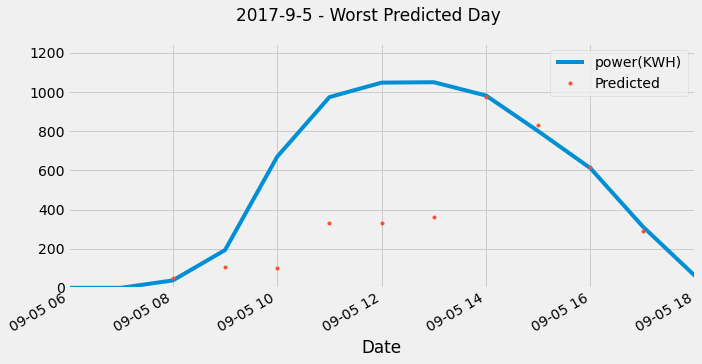

In [17]:
def plot_one(data, day, title):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    _ = data[['power(KWH)','Predicted']].plot(ax=ax, style=['-','.'])
    ax.set_ylim(0, 1250)
    ax.set_xbound(lower=day+' 06:00', upper=day +' 18:00')
    plot = plt.suptitle(day+ ' - ' + title +' Predicted Day ')

# plot worst day
plot_one(test_days, Worst_date, 'Worst')

Plotting best predicted day.

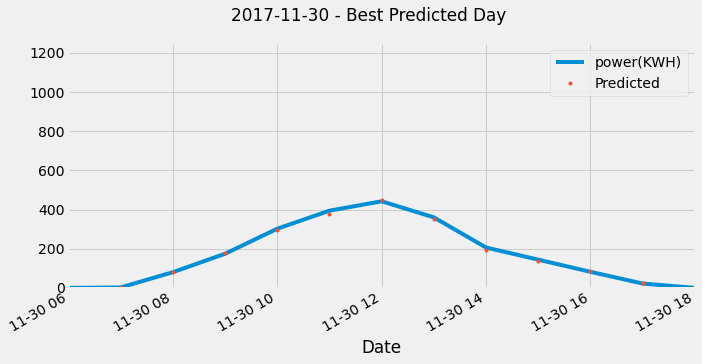

In [18]:
# plot best day
plot_one(test_days, Best_date, 'Best')